# Sentiment Analysis of Amazon's customer reviews
**Author:** Goundo Sidibe <br>
**Sources:** *https://jmcauley.ucsd.edu/data/amazon/*<br>
**Reference:** *https://www.youtube.com/watch?v=o1Bb7G4szQQ&t=1203s
        
        
## Introduction to the Case study

**Objective.** 
 Since the Amazon website gives consumers the ability to write comments about different products and services, huge amounts of reviews have become available. The need to analyse those reviews to understand consumers’  has increased for sellers. However, it is difficult to read all the reviews for a particular item especially for the popular items with many comments. To simplify this process, sentiment analysis is applied in which machine learning algorithms are used to extract the sentiments of reviews. NLP is being processed in this documentation. SVM and Naive Baye machine algorithm are used to classify amazon reviews because it was found through my research that this model exhibit better accuracy when classifying text. I would also implement a logistic regression algorithm as is a binary classifier. The best machine learning model is then deployed to an interactive dashboard that would showcase the data in a simple and organise manner to the amazon sellers.


**Problem Statement.**  
* Which machine learning model performs better in terms of accuracy on the Amazon reviews?
* How to detect the aspects of sentiments shown in the reviews effectively? 
<br><br>
The first question underlines the need to manage a large amount of data ( reviews) automatically and improve the performance of the sentiment classification model. The second question focuses on the emphasis to identify the sentiments of the reviews.

**Analytical Context.** The data is a set of reviews in CSV file format. In this project, I combined some text processing procedures and developed some classification models that are capable of classifying reviews by sentiment.

The things I have done are:
1. Read and analyze the input text data and the corresponding response variables (ratings)
2. Perform basic pre-processing to prepare the data for modeling
3. Learn and apply various ways of featurizing the reviews text
4. Build several machine learning models to classify text as either exhibiting positive or negative sentiment (1 or 0).
5. Compared the models
6. Over-sampling the inbalance data
7. Under-sapling the inbalance data
8. Metrics - ROC and Confusion Matrix

## Importing the packages 

The first four packages are: ```pandas```,``` numpy```, ```matplotlib``` and ``` seaborn```. I imported these packages using the keyword ``import``and  changed the name from ``pandas`` to ```pd```,```numpy``` to ```np```,```matplotlib``` to ```plt```and ```seaborn``` to ```sns```, using the keyword ``as``.

I also imported `nltk`, `sklearn`, `collections` and `wordcloud` packages for processing our text component. The `sklearn` package will be used to build the machine learnings models.



In [1]:
# General packages
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os

# NLP packages
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
# from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from wordcloud import WordCloud

#Model pakages
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

# Metric pakages
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

from pylab import rcParams
import warnings
warnings.filterwarnings("ignore")
rcParams['figure.figsize'] = 20, 10
plt.style.use('ggplot')

The dataset collected from ucds.eu contains information of 10,261 customers written reviews on Amazon musical instruments. Each review contains textual feedback along with a 1-to-5 star rating system (1 being least satisfied and 5 being most satisfied). The following attributes are available in the data:

1. **reviewerID:** ID of the reviewer.
2. **asin:** ID of the product.
3. **reviewerName:** name of the reviewer.
4. **helpful:** helpfulness rating of the review.
5. **reviewTex:** text of the review.
6. **overall:** rating of the product.
7. **summary:** summary of the review.
8. **unixReviewTime:** time of the review (unix time).
9. **reviewTime:** time of the review (raw).

## Reading and performing basic analysis of the data

 Read the available data and perform some high-level analysis on it:

In [2]:
amazon_df = pd.read_csv('/Users/goundosidibe/Documents/konbert-export-8c6dfc1aa7f94.csv')
amazon_df.head(3)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0,0]","Not much to write about here, but it does exac...",5.0,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13,14]",The product does exactly as it should and is q...,5.0,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1,1]",The primary job of this device is to block the...,5.0,It Does The Job Well,1377648000,"08 28, 2013"


In [3]:
amazon_df.shape

(10261, 9)

In [4]:
amazon_df = amazon_df.dropna(subset=['reviewText'])

In [5]:
#Converting the reviews format to string
amazon_df.reviewText= amazon_df.reviewText.astype('str')

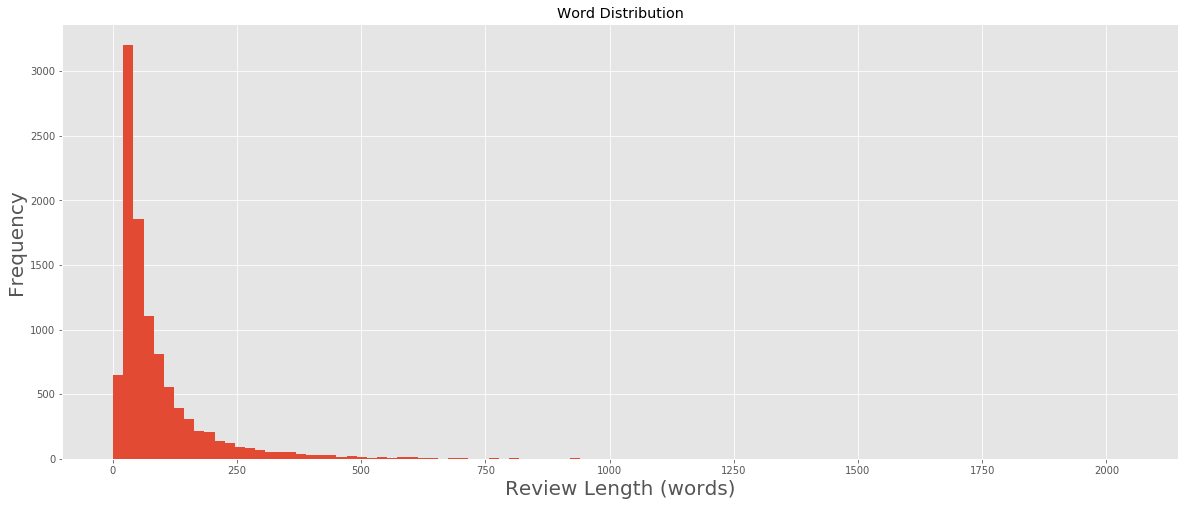

In [6]:
#Looking at the distribution of number of words per review
#applying a lambda function to splits each complete review by spaces 
words_per_review = amazon_df.reviewText.apply(lambda x: len(x.split(" ")))
words_per_review.hist(bins = 100, figsize=(20,8))
plt.title('Word Distribution')
plt.xlabel('Review Length (words)', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.show()

In [7]:
print('Average words:', words_per_review.mean())
print('Skewness:', words_per_review.skew())

Average words: 91.72869124244197
Skewness: 4.843791756248633


The number of words per review is highly positively skewed with a mean of 91. This means that on average, the reviews have 99 words.

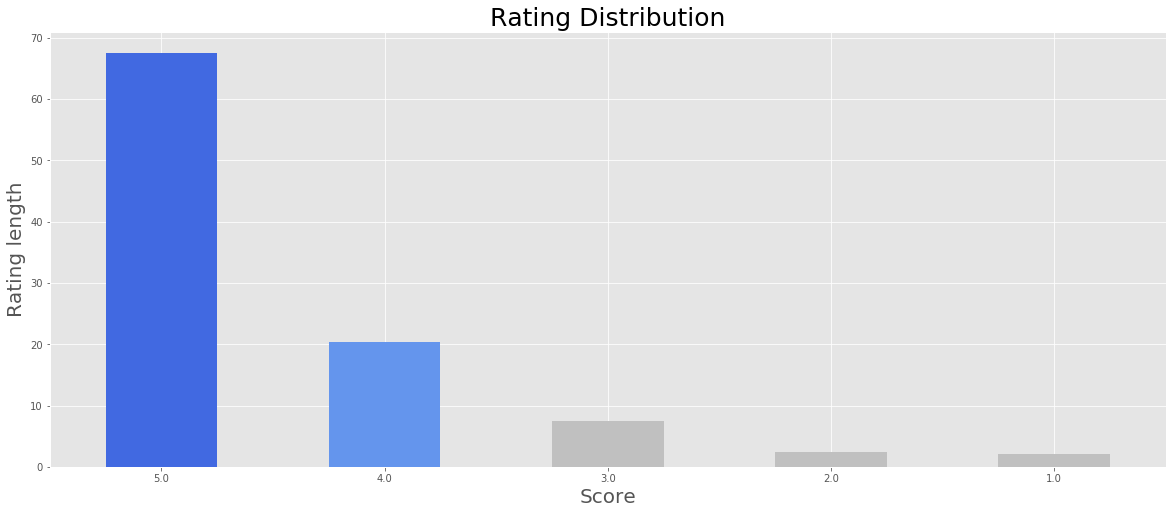

In [8]:
#Looking at the distribution of ratings
percent_val = 100 * amazon_df['overall'].value_counts()/len(amazon_df)
percent_val.plot.bar(figsize=(20,8), color=['royalblue','cornflowerblue','silver','silver','silver'])
plt.ylabel('Rating length', fontsize=20)
plt.title('Rating Distribution',fontsize=25)
plt.xticks(rotation=0,horizontalalignment="center")
plt.xlabel('Score', fontsize=20)
plt.show()

The distribution is quite skewed, with a giant number of 5s and very few 3s, 2s, and 1s.

### Text visualization using word clouds (*word clouds* )

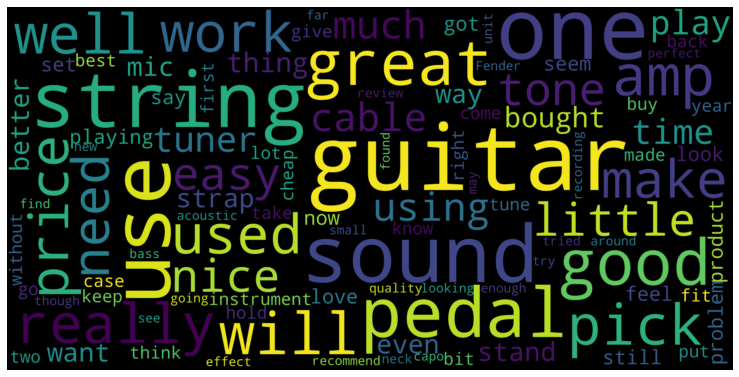

In [9]:
'''The word cloud will show the distribution of the text. 
Words that appear bigger have a high frequency in the review 
and words that appear small have low frequency in the review.'''


word_cloud_text = ''.join(amazon_df['reviewText'])

wordcloud = WordCloud(max_font_size=100, # maximum font size for the largest word
                      max_words=100, # the maximum number of words
                      background_color="black", # background color for the word cloud image
                      scale = 10, # scaling between computation and drawing
                      width=800, # width of the canvas
                      height=400 # height of the canvas
                     ).generate(word_cloud_text)

plt.figure(figsize=(13,10))
plt.imshow(wordcloud, 
           interpolation="bilinear") # makes the image smoothly
plt.axis("off")
plt.show()



The wordcloud indicates that many of the reviews talk about music-related things - guitar, sound, tuner, play, pedal. There are more positive words like good, easy, great. The only negative word that appears is "problem".  This word cloud correlates with the rating distributions as there were more positive rating and positive words.

### Standardizing the ratings for sentiment analysis 

In [10]:
'''
In the following code, the ratings are be converted to binary values 
and used as the target values.

Ratings of 4 or 5 will be mapped to 1 and will be related to positive reviews.
Ratings of 1 or 2 will get mapped to 0 and will be related to negative reviews.
Ratings of 3 will get removed since they will represent neutral reviews.
'''
amazon_df['sentiment_rating'] = np.where(amazon_df.overall > 3,1,0)

#Removing neutral reviews 
amazon_df = amazon_df[amazon_df.overall != 3]

#Printing the counts of each class
amazon_df['sentiment_rating'].value_counts()

1    9015
0     467
Name: sentiment_rating, dtype: int64

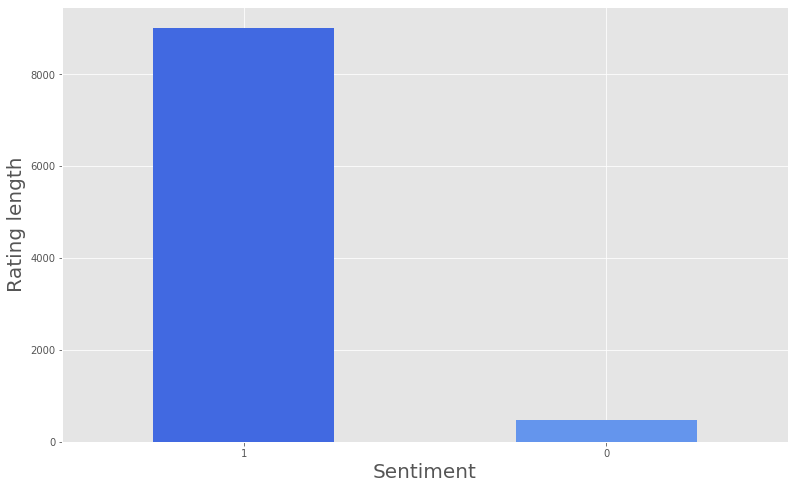

In [11]:
amazon_df.sentiment_rating.value_counts().plot.bar(figsize=(13,8),color=['royalblue','cornflowerblue'])
plt.ylabel('Rating length', fontsize = 20)
plt.xticks(rotation=0,horizontalalignment="center")
plt.xlabel('Sentiment', fontsize=20)

plt.show()

The following observation is a class imbalance as there is a huge difference between the two classes. 9022 of the reviews are positive, and 467 of the reviews are negative. The problem which this, is that models will predict high accuracy on the positive sentiment, but fail to capture the negative sentiment as there are not enough examples. To deal with this problem, first, the following dataset would be used on the machine learning models and a Reciever Operator Characteristic (ROC) would be used to evaluate how well the models have classified the negative reviews. The if the models can not classify the negative reviews accuraly, oversample would be used to duplicate examples from the negative class in the training dataset before fitting a model. This can balance the class distribution but does not provide any additional information to the model.If oversample does not solve the accuray , undersample would be used.

## Pre-processing

Text-processing is crucial before building a machine learning model. Text-processing includes:
1. Converting words to lower/upper case
2. Removing special characters
3. Removing stopwords and high/low-frequency words
4. Stemming/lemmatization

### 1. Converting words to lower/upper case

In [12]:
#converting all of the words into a consistent case format - lowercase
amazon_df['reviews_text_new'] = amazon_df['reviewText'].str.lower()

In [13]:
#reviews not converted to lowercase
token_lists = [word_tokenize(each) for each in amazon_df['reviewText']]
tokens = [item for sublist in token_lists for item in sublist]
print("Number of unique tokens then: ",len(set(tokens)))

#reviews converted to lowercase
token_lists_lower = [word_tokenize(each) for each in amazon_df['reviews_text_new']]
tokens_lower = [item for sublist in token_lists_lower for item in sublist]
print("Number of unique tokens now: ",len(set(tokens_lower)))

Number of unique tokens then:  33790
Number of unique tokens now:  29310


The number of tokens has gone down by 13% just from normalizing the corpus.

### 2. Removing special characters

People often use special characters (emojis, exclamation marks, commas, symbols )to express their emotions. The presence of exclamation marks clearly indicates something about the underlying sentiment, so it's not going to be removed, but non-emotionally charged punctuation such as commas, periods, and semicolons is safe to remove.

In [14]:
# Selecting non alpha numeric charactes that are not spaces
spl_chars = amazon_df['reviews_text_new'].apply(lambda review: 
            [char for char in list(review) if not char.isalnum() and char != ' '])

## Getting list into a single list
flat_list = [item for sublist in spl_chars for item in sublist]

##  gives a list unique special characters that are presented on the reviews
set(flat_list)

{'!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 '{',
 '|',
 '}',
 '~'}

In [15]:
'''
Removing the special characters from the reviews by applying the regular expression 
[^A-Za-z0-9 ]. The regular expression accepts upper case character, lower case characters,  number characters only.  Other type or characters are removed.
'''
review_backup = amazon_df['reviews_text_new'].copy()
amazon_df['reviews_text_new'] = amazon_df['reviews_text_new'].str.replace(r'[^A-Za-z0-9 ]+', ' ')

In [16]:
#Seeing how the reviews change after removing special characters:
print("- Old Review -")
print(review_backup.values[6])
print("\n- New Review -")
print(amazon_df['reviews_text_new'][6])

- Old Review -
i have used monster cables for years, and with good reason. the lifetime warranty is worth the price alone. simple fact: cables break, but getting to replace them at no cost is where it's at.

- New Review -
i have used monster cables for years  and with good reason  the lifetime warranty is worth the price alone  simple fact  cables break  but getting to replace them at no cost is where it s at 


From the statement above, we can see that the semicolumn, comma and full stop has been remove and replace with space.

### 3. Stopwords and high/low frequency words
Stopwords such as "but, maybe, also" appears very frequently in the English language. Stopwords do not give any additional meaning to the reviews, so the following code would remove it.

In [17]:
from nltk.corpus import stopwords
# Reviewing what languages are available in the nltk package
print('Available languages for NLTK v.3.4.5: ')
print(stopwords.fileids())

Available languages for NLTK v.3.4.5: 
['arabic', 'azerbaijani', 'danish', 'dutch', 'english', 'finnish', 'french', 'german', 'greek', 'hungarian', 'indonesian', 'italian', 'kazakh', 'nepali', 'norwegian', 'portuguese', 'romanian', 'russian', 'slovene', 'spanish', 'swedish', 'tajik', 'turkish']


In [18]:
#Reviewing the list of English stopwords
noise_words = []
eng_stop_words = stopwords.words('english')
eng_stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [19]:
#Testing the stopword in the review
stop_words = set(eng_stop_words)
without_stop_words = []
stopword = []
sentence = amazon_df['reviews_text_new'][0]
words = nltk.word_tokenize(sentence)

for word in words:
    if word in stop_words:
        stopword.append(word)
    else:
        without_stop_words.append(word)

print('-- Original Sentence --\n', sentence)
print('\n-- Stopwords in the sentence --\n', stopword)
print('\n-- Non-stopwords in the sentence --\n', without_stop_words)

-- Original Sentence --
 not much to write about here  but it does exactly what it s supposed to  filters out the pop sounds  now my recordings are much more crisp  it is one of the lowest prices pop filters on amazon so might as well buy it  they honestly work the same despite their pricing 

-- Stopwords in the sentence --
 ['not', 'to', 'about', 'here', 'but', 'it', 'does', 'what', 'it', 's', 'to', 'out', 'the', 'now', 'my', 'are', 'more', 'it', 'is', 'of', 'the', 'on', 'so', 'as', 'it', 'they', 'the', 'same', 'their']

-- Non-stopwords in the sentence --
 ['much', 'write', 'exactly', 'supposed', 'filters', 'pop', 'sounds', 'recordings', 'much', 'crisp', 'one', 'lowest', 'prices', 'pop', 'filters', 'amazon', 'might', 'well', 'buy', 'honestly', 'work', 'despite', 'pricing']


In [20]:
#Removing stopwords from the reviews

def stopwords_removal(stop_words, sentence):
    return [word for word in nltk.word_tokenize(sentence) if word not in stop_words]

amazon_df['reviews_text_nonstop'] = amazon_df['reviews_text_new'].apply(lambda row: stopwords_removal(stop_words, row))
amazon_df[['reviews_text_new','reviews_text_nonstop']]

,reviews_text_new,reviews_text_nonstop
0,not much to write about here but it does exac...,"[much, write, exactly, supposed, filters, pop,..."
1,the product does exactly as it should and is q...,"[product, exactly, quite, affordable, realized..."
2,the primary job of this device is to block the...,"[primary, job, device, block, breath, would, o..."
3,nice windscreen protects my mxl mic and preven...,"[nice, windscreen, protects, mxl, mic, prevent..."
4,this pop filter is great it looks and perform...,"[pop, filter, great, looks, performs, like, st..."
...,...,...
10256,great just as expected thank to all,"[great, expected, thank]"
10257,i ve been thinking about trying the nanoweb st...,"[thinking, trying, nanoweb, strings, bit, put,..."
10258,i have tried coated strings in the past incl...,"[tried, coated, strings, past, including, elix..."
10259,well made by elixir and developed with taylor...,"[well, made, elixir, developed, taylor, guitar..."


### 4. Stemming & lemmatization
**Stemming** works by cutting off the end or the beginning of the word, taking into account a list of common prefixes and suffixes that can be found.

**Lemmatization** takes into consideration the morphological analysis of the words. So lemmatization considers the grammar of the word and tries to find the root word instead of just getting to the root word by brute force methods.

In [21]:
from nltk.stem import PorterStemmer, LancasterStemmer 
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.corpus import wordnet

porter = PorterStemmer()
lancaster = LancasterStemmer()
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/goundosidibe/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [22]:
#Selecting the columns that are going to e used to train the model
amazon_df[['reviewText','overall','sentiment_rating']].head(5)

,reviewText,overall,sentiment_rating
0,"Not much to write about here, but it does exac...",5.0,1
1,The product does exactly as it should and is q...,5.0,1
2,The primary job of this device is to block the...,5.0,1
3,Nice windscreen protects my MXL mic and preven...,5.0,1
4,This pop filter is great. It looks and perform...,5.0,1


### Bag-of-words and n-grams

In [23]:
'''The following code uses the bag of words model to convert text documents 
into corresponding numerical features.'''

from nltk import ngrams

#using bag of words to analyse the frequency of a word appearing in the text.
# from sklearn.feature_extraction.text import CountVectorizer

vec = TfidfVectorizer()
X = vec.fit_transform(amazon_df['reviews_text_new'])
df = pd.DataFrame(X.toarray(), columns = vec.get_feature_names())
df.head()

,00,000,000s,001,003,004,0045,007,008,008ex,...,zombie,zone,zoom,zooms,zt,zune,zvex,zylgian,zz,zzounds
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
#Creating a python object of the class CountVectorizer

bow_counts = TfidfVectorizer(tokenizer= word_tokenize,
                             ngram_range=(1,4))

bow_data = bow_counts.fit_transform(amazon_df.reviews_text_new)

In [25]:
bow_data

<9482x1581188 sparse matrix of type '<class 'numpy.float64'>'
	with 3084484 stored elements in Compressed Sparse Row format>

A parse matrix of 9489 observations (number of rows of the reviews_text_new series) has been built, and 1581188 columns corresponding to the features extracted by means of the representation of the 1-gram count of the user reviews.

### Train-Test Split

In [26]:
X_train, X_test, y_train, y_test = train_test_split(bow_data, # Features
                                amazon_df['sentiment_rating'], # Target variable
                                test_size = 0.2, # 20% test size
                                random_state = 0) # random state for replication purposes

In [27]:
y_train.value_counts()/y_train.shape[0]

1    0.950692
0    0.049308
Name: sentiment_rating, dtype: float64

The training dataset contains only 4% of negative review which is not enough samples for the model to understand how negative reviews are structure.

### Training the models (LogisticRegression,Naive Bayes, SVM)

In [28]:
# logistic regression
model1 = LogisticRegression()
# Naive bayes
model2 = MultinomialNB()
# SVM
model3 = SVC(probability=True)

# fit model
model1.fit(X_train, y_train)
model2.fit(X_train, y_train)
model3.fit(X_train, y_train)

# predict probabilities
pred_prob1 = model1.predict_proba(X_test)
pred_prob2 = model2.predict_proba(X_test)
pred_prob3 = model3.predict_proba(X_test)

In [29]:
from sklearn.metrics import roc_auc_score

# auc scores
auc_score1 = roc_auc_score(y_test, pred_prob1[:,1])
auc_score2 = roc_auc_score(y_test, pred_prob2[:,1])
auc_score3 = roc_auc_score(y_test, pred_prob3[:,1])

print(auc_score1, auc_score2, auc_score3 )

0.8810647783897194 0.5335157237202871 0.9099134539732494


In [30]:
from sklearn.metrics import roc_curve

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob1[:,1], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, pred_prob2[:,1], pos_label=1)
fpr3, tpr3, thresh3 = roc_curve(y_test, pred_prob3[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

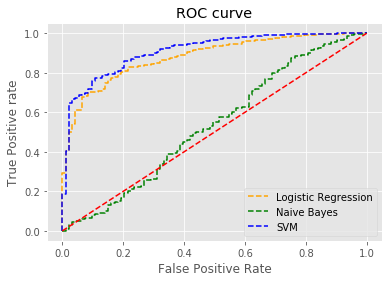

In [31]:

# calculate scores

'''
The y-axis shows the True Positive rates, which shows positive reviews that correctly 
predicted as positive  by the model

The x-axis shows the False Positive rates, which shows the proportion of negative 
reviews that were correctly classified as negative by the model.

The red diagonal lines show where True positive = False positive rate. Any point in this 
line means that the proportion of positive reviews is the same as the proportion of 
negative review.


'''

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Logistic Regression')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='Naive Bayes')
plt.plot(fpr3, tpr3, linestyle='--',color='blue', label='SVM')
plt.plot(p_fpr, p_tpr, linestyle='--', color='red')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

All the models gave an accuracy of 95%.
From the ROC metric, we can see that SVM performs better at classifying the reviews compare to the other models.  Surprising logistic regression performed better than Naive Bayes.

To evaluate the effectiveness of the models, I created a confusion matrix to summarise the classification.

#### Logistic Regression Classification Report

Logistic Regression Classification Report
accuracy : 0.9509752240379546 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        93
           1       0.95      1.00      0.97      1804

    accuracy                           0.95      1897
   macro avg       0.48      0.50      0.49      1897
weighted avg       0.90      0.95      0.93      1897
 



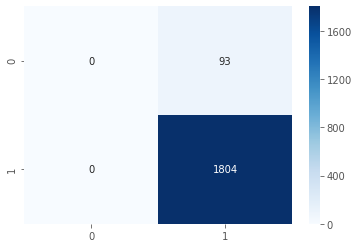

In [32]:
# Logistic Regression Classification Report
y_pred = model1.predict(X_test)
print('Logistic Regression Classification Report')
print('accuracy :',accuracy_score(y_test,y_pred),"\n")
print(classification_report(y_test,y_pred),"\n")


#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix,cmap="Blues", annot=True, fmt='g')


#### Naive Baye Classification Report

Naive Baye Classification Report
accuracy : 0.9509752240379546 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        93
           1       0.95      1.00      0.97      1804

    accuracy                           0.95      1897
   macro avg       0.48      0.50      0.49      1897
weighted avg       0.90      0.95      0.93      1897
 



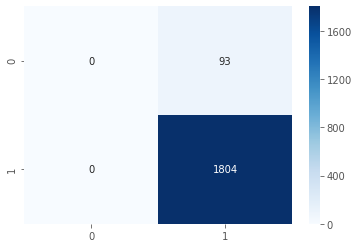

In [33]:
# Naive Baye Classification Report
y_pred = model2.predict(X_test)
print('Naive Baye Classification Report')
print('accuracy :',accuracy_score(y_test,y_pred),"\n")
print(classification_report(y_test,y_pred),"\n")
# confusion_matrix = confusion_matrix(y_test, y_pred)
# print("Naive Baye confusion matrix:","\n",confusion_matrix)

#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix,cmap="Blues", annot=True, fmt='g')

SVM Classification Report
accuracy : 0.9509752240379546 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        93
           1       0.95      1.00      0.97      1804

    accuracy                           0.95      1897
   macro avg       0.48      0.50      0.49      1897
weighted avg       0.90      0.95      0.93      1897
 



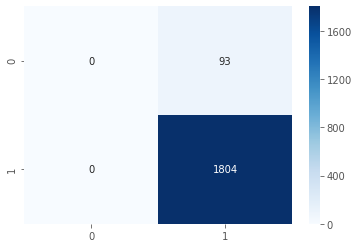

In [34]:
# SVM Classification Report
from sklearn.metrics import confusion_matrix
y_pred = model3.predict(X_test)
print('SVM Classification Report')
print('accuracy :',accuracy_score(y_test,y_pred),"\n")
print(classification_report(y_test,y_pred),"\n")
# confusion_matrix = confusion_matrix(y_test, y_pred)
# print("SVM confusion matrix:","\n",confusion_matrix)

#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix,cmap="Blues", annot=True, fmt='g')

To tackle this problem, the dataset needs to be resampled as it is imbalanced. First, the over-sampling method will be applied to the imbalanced dataset which consists of duplicating the minority class samples ( negative class). If any of the models get high accuracy on the over-sampled dataset, then that would be considered the best model. If the models did not perform well on the over-sampled dataset, under-sampling will be applied which consist of removing samples from the majority class (positive class) and make it equal to the minority class( negative ) class.

### Oversampling  the imbalance data

Over-sampling add some duplicates the minority class(negative class).

In [35]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# instantiating the random over sampler 
ros = RandomOverSampler()
# resampling X_train, y_train
X_ros, y_ros = ros.fit_resample(X_train, y_train)
# new class distribution 
print(Counter(y_ros))

Counter({1: 7211, 0: 7211})


In [36]:
# logistic regression
model1 = LogisticRegression()
# Naive bayes
model2 = MultinomialNB()
# svm
model3 = SVC(probability=True)

# fit model
model1.fit(X_ros, y_ros)
model2.fit(X_ros, y_ros)
model3.fit(X_ros, y_ros)

# predict probabilities
pred_prob1 = model1.predict_proba(X_test)
pred_prob2 = model2.predict_proba(X_test)
pred_prob3 = model3.predict_proba(X_test)

In [37]:
# from sklearn.metrics import roc_auc_score
# auc scores
auc_score1 = roc_auc_score(y_test, pred_prob1[:,1])
auc_score2 = roc_auc_score(y_test, pred_prob2[:,1])
auc_score3 = roc_auc_score(y_test, pred_prob3[:,1])

print(auc_score1, auc_score2, auc_score3)

0.9020635147700451 0.9116598717306821 0.9121426698137949


In [38]:
# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob1[:,1], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, pred_prob2[:,1], pos_label=1)
fpr3, tpr3, thresh3 = roc_curve(y_test, pred_prob3[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

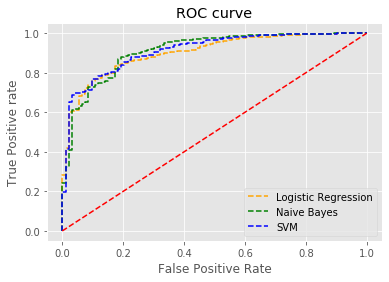

In [39]:

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Logistic Regression')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='Naive Bayes')
plt.plot(fpr3, tpr3, linestyle='--',color='blue', label='SVM')
plt.plot(p_fpr, p_tpr, linestyle='--', color='red')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

After over-sampling the dataset all the models' accuracy is around  90%. It difficult to know which model produces the best result, therefore I used a confusion matrix to identify which model has classified the positive and negative reviews accurately.

Logistic Regression Classification Report


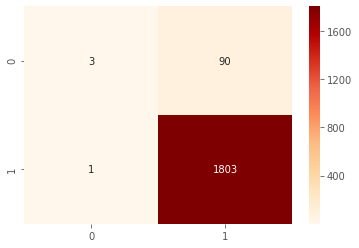

In [41]:
from sklearn.metrics import confusion_matrix
# Logistic Regression Classification Report
y_pred = model1.predict(X_test)
print('Logistic Regression Classification Report')

#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix,cmap="OrRd", annot=True, fmt='g')


Logistic regression performed poorly on the dataset as negative reviews were incorrectly classified. It seems that over-sampled dataset did not affect logistic regression accuracy as it still can't predict negative reviews.  There is a chance that logistic regression sees negative reviews as noise data and ignores it.

Naive Baye Classification Report


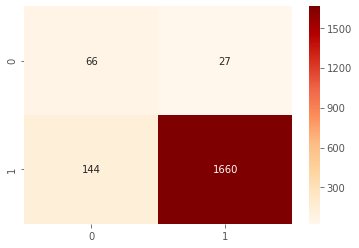

In [42]:
# Naive Baye Classification Report
y_pred = model2.predict(X_test)
print('Naive Baye Classification Report')

#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix,cmap="OrRd", annot=True, fmt='g')

Naive Baye is able to predict 66 negative samples accurately, however, it didn't perform very well on the positive samples as 139 positive reviews were incorrectly classified. Naive Baye performed very well on the over-sampled dataset but is not the best classifier as it still makes mistakes.

Naive Baye Classification Report


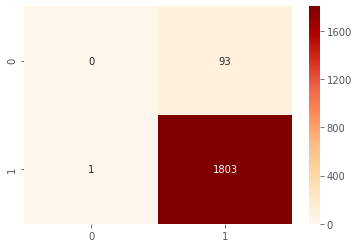

In [43]:
# SVM Classification Report
y_pred = model3.predict(X_test)
print('Naive Baye Classification Report')

#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix,cmap="OrRd", annot=True, fmt='g')

SVM performed poorly on the over-sample dataset. Its accuracy is very similar to logistic regression as it incorrectly classifies all the negative samples, but correctly classified almost all the positive samples.

Overall the oversampled data helps the Naive Baye model to predict negative reviews better but it was not effective to the Logistic regression and SVM  as the accuracies were similar to the imbalanced dataset. 


### Undersampling imbalance data
 under-sampling removes some observations observations of the majority class (positive).This is done until the majority and minority class is balanced out. Undersampling is consider to be a good choice when the dataset is large.

In [44]:
# instantiating the random undersampler
rus = RandomUnderSampler() 
# resampling X, y
X_rus, y_rus = rus.fit_resample(X_train, y_train)
# new class distribution
print(Counter(y_rus))

Counter({0: 374, 1: 374})


In [45]:
# logistic regression
model1 = LogisticRegression()
# Naive bayes
model2 = MultinomialNB()
# svm
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
model3 = SVC(probability=True)

# fit model
model1.fit(X_rus, y_rus)
model2.fit(X_rus, y_rus)
model3.fit(X_rus, y_rus)

# predict probabilities
pred_prob1 = model1.predict_proba(X_test)
pred_prob2 = model2.predict_proba(X_test)
pred_prob3 = model3.predict_proba(X_test)

In [46]:
# auc scores
auc_score1 = roc_auc_score(y_test, pred_prob1[:,1])
auc_score2 = roc_auc_score(y_test, pred_prob2[:,1])
auc_score3 = roc_auc_score(y_test, pred_prob3[:,1])

print(auc_score1, auc_score2, auc_score3)


# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob1[:,1], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, pred_prob2[:,1], pos_label=1)
fpr3, tpr3, thresh3 = roc_curve(y_test, pred_prob3[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)


0.8576162887728583 0.879461411916172 0.8455999809264955


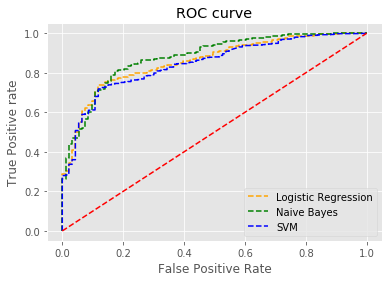

In [47]:
# matplotlib
# import matplotlib.pyplot as plt
# plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Logistic Regression')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='Naive Bayes')
plt.plot(fpr3, tpr3, linestyle='--',color='BLUE', label='SVM')
plt.plot(p_fpr, p_tpr, linestyle='--', color='red')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

From the above observation, it seems like all the models performed well on the under-sample dataset.It difficult to know which model produced the best result, therefore a confusion matrix is used to identify which model has classified the positive and negative reviews accurately.

Logistic Regression Classification Report


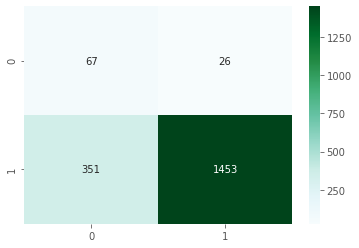

In [48]:
from sklearn.metrics import confusion_matrix
# Logistic Regression Classification Report
y_pred = model1.predict(X_test)
print('Logistic Regression Classification Report')

#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix,cmap="BuGn", annot=True, fmt='g')


The logistic regression is doing better at predicting  negative samples. In this case, we could say that the under-sampled dataset helps the Logistic Regression model to predict the negative reviews better, but it stills make some mistakes.

Naive Baye Classification Report


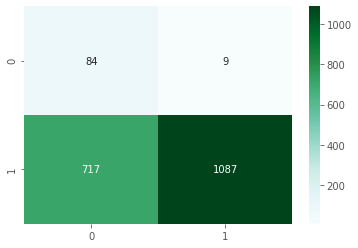

In [49]:
# Naive Baye Classification Report
y_pred = model2.predict(X_test)
print('Naive Baye Classification Report')

#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix,cmap="BuGn", annot=True, fmt='g')

This is the best accuracy. Naive Baye was able to classify most of the positive and negative review accurately. Some samples were classified incorrectly, but it's a minor problem.

Naive Baye Classification Report


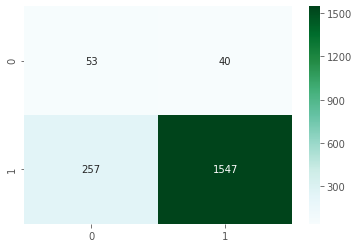

In [50]:
# SVM Classification Report
y_pred = model3.predict(X_test)
print('SVM Report')

#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix,cmap="BuGn", annot=True, fmt='g')

SVM managed to classified 53 negative samples, but it incorrectly misclassified 40 negative samples, which is the vast amount of the undersampled dataset. SVM also made some incorrect misclassification on the positive reviews, but the majority of the positive samples were classified correctly.

### Predicting new data with Naive Bayes

In [51]:
sarcasm_sentence= ["Thanks but no thanks, I'm not willing to pay this monthly sum, far too expensive!."]
X_test = bow_counts.transform(sarcasm_sentence)
predict_s = model2.predict(X_test)
print(predict_s)

[0]


In [52]:
positive_sentence = ["i have bought several of the vitality canned dog food products and have found them all to be of good quality the product looks more like a stew than a processed meat and it smells better my <OOV> is finicky and she appreciates this product better than most"]
X_test = bow_counts.transform(positive_sentence)
predict_p = model2.predict(X_test)
print(predict_p)

[1]


In [53]:
negative_sentence = ["Don't subscribe to Audible books they are still taking money from my account YEARS after finishing with them. The fraud squad from my bank are forcing them to return money they take every month!"]
X_test = bow_counts.transform(negative_sentence)
predict_n = model2.predict(X_test)
print(predict_n)

[0]


# Top 15 words in  positive reviews
To validate our model and interpret its predictions, it is important to look at which words it is using to make decisions. Plotting word importance is simple with Bag of Words and Logistic Regression, since we can just extract and rank the coefficients that the model used for its prediction

In [58]:
l_weights = pd.DataFrame(list(zip(bow_counts.get_feature_names(), # gets all the n-gram feature names
                        model2.coef_[0])), # get the logistic regression coefficients
                          columns= ['words','weights']).sort_values(['weights'], ascending = True) # defining the colunm names



l_weights.head(15)

,words,weights
0,0,-14.277315
1038657,quality and a nice,-14.277315
1038656,quality and a great,-14.277315
1038655,quality and a good,-14.277315
1038654,quality and a,-14.277315
1038652,quality an very robust,-14.277315
1038651,quality an very,-14.277315
1038650,quality an,-14.277315
1038649,quality amps like marshals,-14.277315
1038648,quality amps like,-14.277315


## Top 15 words in negative reviews

In [59]:
lr_weights = pd.DataFrame(list(zip(bow_counts.get_feature_names(), # ge tall the n-gram feature names
                                   model2.coef_[0])), # get the Naive baye coefficients
                          columns= ['words','weights']) # defining the colunm names

# # top-15 more important features for negative reviews
top =lr_weights.sort_values(['weights'], ascending = False) # top-15 more important features for positive reviews
top.head(15)

,words,weights
1255819,the,-11.772042
589283,i,-11.950592
672563,it,-12.111948
119735,and,-12.114644
29627,a,-12.123566
1375508,to,-12.210134
652658,is,-12.437873
1348427,this,-12.469820
883719,of,-12.515660
459691,for,-12.546127


## Conclusion

The machine learning models by default assumed that the dataset was balanced and gave an accuracy of 95% on the training. When the metrics (ROC and confusion matrix) was used to evaluate the model's performance, it was discovered that all the models fail to predict the negative samples and the accuracy score was misleading. The dataset had high imbalance classes which the models always predicted the most common class without performing any analysis of the features and it will have a high accuracy rate, obviously not the correct one. To tackle this problem I oversampled the imbalanced dataset which produced an equal ratio of data to each class. Logistic Regression and SVM performed poorly on the oversampled dataset as it incorrectly classified most of the negative samples, but correctly classified all the positive samples. There is a chance that logistic regression and SVM see negative reviews as noise data and ignores them or because negative data were duplicated it does not learn anything new. Naive Baye classified 70% of the negative samples correctly but it did some misclassification on the positive samples. Overall the oversampled data helps the Naive Baye model to predict negative reviews better, but it could be better. 
I then tried to undersample the dataset, in the hope I would get better results with the models.
Logistic Regression and SVM did better at predicting the negative samples. In this case, we could say that the under-sampled dataset helps the Logistic Regression and SVM  to predict the negative reviews better. Logistic Regression and SVM made misclassification on some positive samples, but it very minor. Naive Baye classified 90% of negative samples correctly which is a huge improvement and classified 60% of positive reviews correctly.  From this observation, I concluded that Naive Baye is the best model for amazon reviews because it produces better accuracy results on the negative samples and it can still classify all the positive samples accurately. I believe that  Naive Baye performed much better than other models because all the data were calculated by the Bayes Theorem and is much faster with its probability calculations. The classifier that was used was Multinomial is with is a good method for any sort of Text classification as it considers the frequency of the word will have better accuracy than just checking for word occurrence.

In the background research, authors got better accuracy with SVM when classifying Amazon reviews. What differentiates my results from their projects,  is that I handle the imbalanced data while they ignored it. In my research, I mentioned biased, sarcasm, negation could mislead the model accuracy.I can confirm that the dataset I used to train the models is not biased. This is because the dataset accurately represents the environment is expected to run into and the data was not modified. However, is hard for me to identify if the dataset contains consciously or unconsciously reflecting stereotypes. The chosen model (Naive Baye) can classified sarcasm accurately. I fitted the following model with the following sarcasm sentence "Thanks but no thanks, I'm not willing to pay this monthly sum, far too expensive! " and it predicted negative which is the correct label. In the future, I would like to take this project to an advanced level, which is performing multi-sentiment classification.


## Future Work 

In this project, I performed binary classification as the models only classified the reviews into two classes(positive, negative). A definite flaw in this method is that text is either categorise into positive/negative classes when there are so many possible emotions attached to it. In the future, I would like to take this project to an advanced level, which is a multi-sentiment classification that would have the following labels l, happy, anger, hate, disgust.
